In [409]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup

imp.reload(sp)

mbins = 1000

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec(gtype='lens')
rp = setup.arcmin_to_rp(20, zleff, sp.zed.cosmo_SRD) * (sp.pa.HH0 / 100.)
theta_edges = setup.setup_rp_bins(0.2, 25, 10)
theta_cents = setup.rp_bins_mid(theta_edges)
print(theta_cents)
print(rp)

[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]
10.138759220905907


## We start with the case where there is no Intrinsic Alignment

First get F($\theta$) using dependance from Sara $\Pi_{close} = r_{p} ; r_{p} > 2 : \Pi_{close} = 2Mpch^{-1} ; r_{p} \leq 2Mpch^{-1}$

In [3]:
F = sp.get_F(theta_dependence=False)
F_theta = sp.get_F(theta_dependence=True)

Check values of F are sensible for both cases. 
We would expect F without theta dependence to be much larger across these scales becuase the projection is 100Mpc h-1, whereas the max projection with theta depedence is ~ 10Mpc h-1

In [4]:
print(F)
print(F_theta)

0.02073898968122842
[0.0006165  0.0006165  0.0006165  0.0006165  0.0006165  0.0006165
 0.00080148 0.00129893 0.00210512 0.00341169]


Next calculate $B(\theta) - 1$ (or load from boost file, comment out accordingly)

In [5]:
#B_min1, theta = sp.get_boosts()
B_min1 = np.load('generated_data/Boost_data_year1.npz')['B_min1']
theta = np.load('generated_data/Boost_data_year1.npz')['theta']

In [6]:
print(B_min1)
print(theta)

[0.09429856 0.05354952 0.03250654 0.02241816 0.0159059  0.01095674
 0.00716792 0.00437449 0.00244329 0.00122134]
[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]


For LSST we have the multiplicative bias requirements:

Y1 $\Delta m \leq 0.013$

Y10 $\Delta m \leq 0.003$

In [404]:
# year 1 mbias
delM_max = 0.013
# year 10 mbias
#delM = 0.013

delM_minus_delMp = np.logspace(np.log10(1E-6), np.log10(+2.*delM_max), 1000)

#### Next get $\gamma_{t}$ for a range of $\Delta m$

Assumptions:
- Define scale factors in gM power spectrum as lens scale factors

In [8]:
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.) + 10, 1024).astype(int))

# compute angular power spectrum for galaxy-galaxy lensing
Cl_gM, tracer1, tracer2 = sp.get_LSST_Cl(ell, 'gm')

### Now we combine everything on the LHS to get RHS for different combinations of $\Delta m$
$\frac{\tilde{\gamma}_{t} - \tilde{\gamma}_{t}^{\prime}}{B(\theta) - 1 + F} = 
    (\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$
    
IA acts radially so detracts from lensing signal. Therefore we take most from least contaminated

In [408]:
gammat = sp.get_gammat_noIA(Cl_gM, theta, ell)
delM_yL_PA = np.zeros([1000, len(theta)])  
for i in range(1000):
        delM_yL_PA[i,:] = delM_minus_delMp[i] * (gammat /  (B_min1 + F_theta))

The rows correspond to bias on gammat, the columns gammat_prime and the 3rd dim is the values for different theta

#### Various plots checking things look sensible

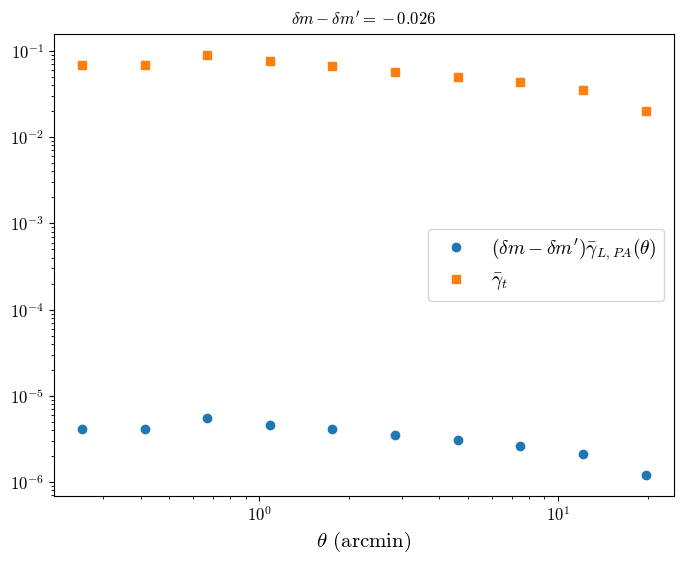

In [248]:
plt.figure(figsize=[8,6])
plt.plot(theta, abs(delM_yL_PA[50,:]), linewidth=0, marker='o')
plt.plot(theta, gammat/(B_min1 + F_theta), linewidth=0, marker='s')
plt.title(r'$\delta m - \delta m^{\prime} = %g$'%delM_minus_delMp[0])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend([r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$',
            r'$\bar{\gamma}_{t}$', r'$\bar{\gamma}_{t}^{\prime}$'],fontsize=14)

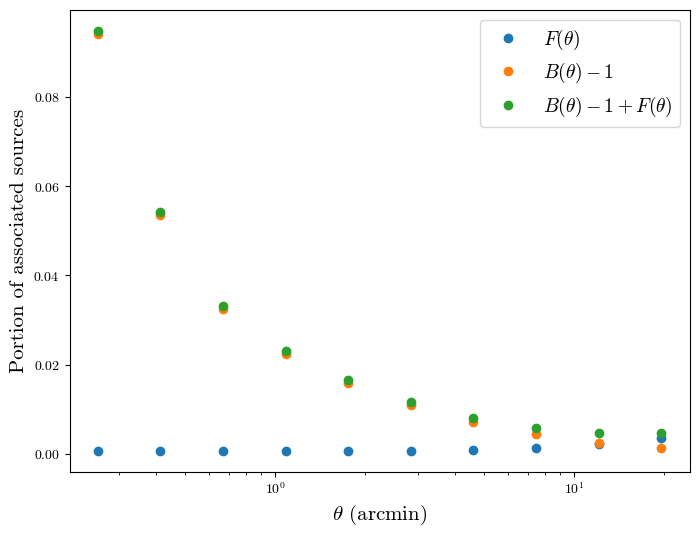

In [14]:
plt.figure(figsize=[8,6])
plt.plot(theta, F_theta, linewidth=0, marker='o')
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.plot(theta, B_min1 + F_theta, linewidth=0, marker='o')
plt.ylabel(r'Portion of associated sources', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.legend([r'$F(\theta)$', r'$B(\theta) - 1$', 
            r'$B(\theta) - 1 + F(\theta)$'], fontsize=14);

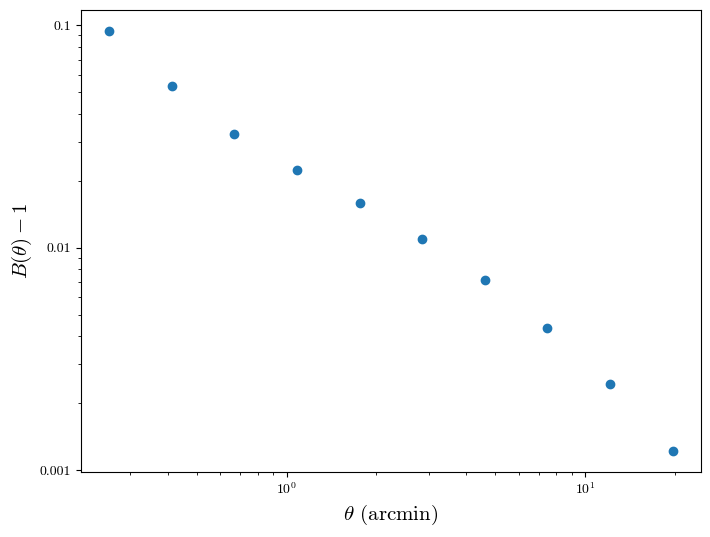

In [15]:
plt.figure(figsize=[8,6])
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.ylabel(r'$B(\theta) - 1$', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.yticks([1E-1,1E-2,1E-3], ['0.1','0.01','0.001']);

### Lets try some theortetical IA modelling with CCL
- Take $\bar{A}_{IA} = 5.$ and $\sigma_{A} = 3.9$ from SRD
- $f_{red} = 0.16$ from L2018
- A should be a function of redshift, but for now we will assume it is unrealted to the redshift (DISCUSS WITH DANIELLE)
- Let's assume a pessimistic a = 0.65 (Singh 2016)

In [354]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec('source')
z_s, dndz_s, zseff = sp.zed.get_dndz_spec('lens')

A_IA = 0.16 * 5. * np.ones(len(z_l))

lensTracer = ccl.NumberCountsTracer(sp.halo.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                    bias=(z_l, sp.lens_bias(z_l)))
intrinsicTracer = ccl.WeakLensingTracer(sp.halo.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, A_IA))

In [355]:
# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E2, 3000)

a_l = 1. / (1. + z_l)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.flip(a_l))

# compute aps for galaxy-intrinsicshape
Cl_IA = ccl.angular_cl(sp.halo.cosmo_SRD, lensTracer, intrinsicTracer, ell, p_of_k_a=pk_gMf)

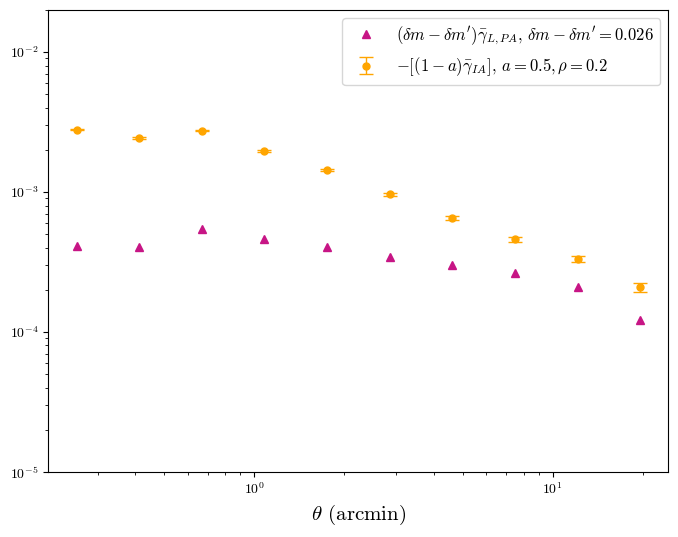

In [393]:
y_IA = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_IA, theta / 60., type='NG')
bar_yIA = y_IA / (B_min1 + F)

a = 0.5
yIA_1mina = (1.-a)*bar_yIA

covariance = np.load('generated_data/lsst-y1-gamma-gamma-covmat.npz')
IA_sig = np.sqrt(np.diag(covariance['cov'])) / (B_min1 + F)

plt.figure(figsize=[8,6])
plt.errorbar(theta, -yIA_1mina, IA_sig, linewidth=0, marker='o', markersize=5., color='orange',
            elinewidth=1., capsize=5.)
plt.plot(theta, delM_yL_PA[99,:], linewidth=0, marker='^', color='mediumvioletred')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1E-5, 2E-2])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.legend([r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}$, $\delta m - \delta m^{\prime} = %g$'%delM_minus_delMp[99],
            r'$-[(1-a)\bar{\gamma}_{IA}]$, $a=%g,\rho=%g$'%(a,0.2)], 
           fontsize=12)
plt.savefig('IA_vs_artefact_forecast_prelim.png', dpi=300)

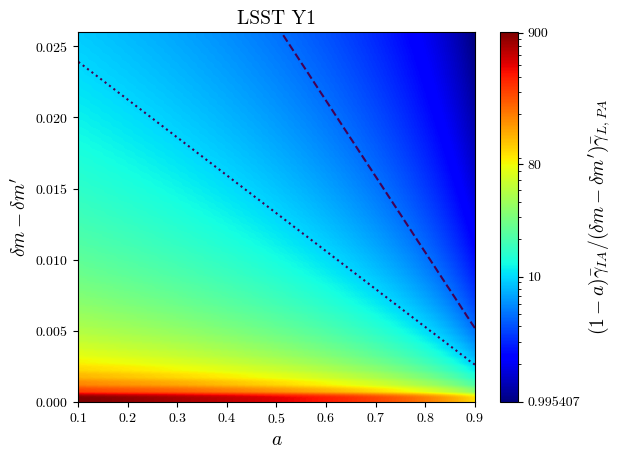

In [151]:
a_off = np.linspace(0.1, 0.9, 1000)

yIA_of_a = np.zeros([len(a_off),len(bar_yIA)])
for i in range(len(a_off)):
    yIA_of_a[i,:] = -(1.-a_off[i])*bar_yIA
    
SNR = np.zeros([len(delM_minus_delMp),len(a_off)])
for i in range(len(a_off)):
    for j in range(len(delM_minus_delMp)):
        SNR[j,i] = np.mean(abs((yIA_of_a[i,:] - IA_sig[:]) / delM_yL_PA[j,:]))

            
A,M = np.meshgrid(a_off,delM_minus_delMp)        
        
fig, ax = plt.subplots()

snr10 = ax.contour(A,M,SNR,[10],linestyles='dotted')
snr5 = ax.contour(A,M,SNR,[5], linestyles='--')

cax = ax.imshow(np.flip(SNR,axis=0), extent=[a_off[0],a_off[-1],delM_minus_delMp[0],delM_minus_delMp[-1]], aspect='auto', 
           norm=mpl.colors.LogNorm(), cmap='jet')

cbar = fig.colorbar(cax, ticks=[SNR.min(),10,80,900])
cbar.ax.set_yticklabels(['%g'%SNR.min(),'10','80','900']);
cbar.set_label(r'$(1-a)\bar{\gamma}_{IA}/(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}$', fontsize=14)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$\delta m - \delta m^{\prime}$', fontsize=14)
plt.title('LSST Y1', fontsize=14)
plt.ylim([0,0.026])
plt.savefig('SNR_colorbar.png',dpi=300)

In [126]:
yIA_of_a[0,:]

array([0.03138349, 0.02735656, 0.03081521, 0.0220345 , 0.01603916,
       0.01081686, 0.00735085, 0.00514651, 0.00370888, 0.00234418])

In [124]:
delM_yL_PA[0,:]

array([-0.00178272, -0.00176173, -0.00234915, -0.00199799, -0.00175544,
       -0.00149474, -0.00130971, -0.00113669, -0.00091054, -0.0005235 ])

In [128]:
np.mean(yIA_of_a[0,:]+delM_yL_PA[20,:])

0.0148043552403741

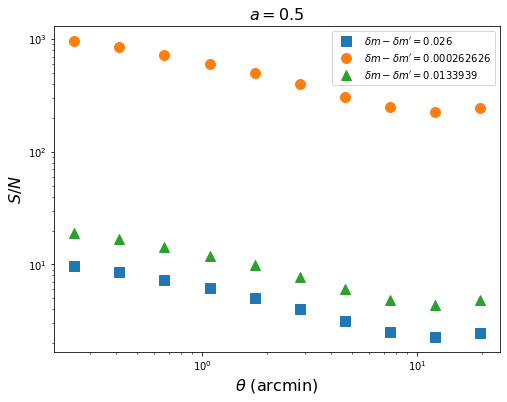

In [177]:
plt.figure(figsize=[8,6])

SNR_min = -yIA_1mina / delM_yL_PA[99,:]
SNR_max = -yIA_1mina / delM_yL_PA[50,:]
SNR_mid = -yIA_1mina / delM_yL_PA[75,:]

plt.plot(theta, SNR_min, linewidth=0, marker='s', markersize=10)
plt.plot(theta, SNR_max, linewidth=0, marker='o', markersize=10)
plt.plot(theta, SNR_mid, linewidth=0, marker='^', markersize=10)
        
plt.ylabel(r'$S/N$', fontsize=16)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.title(r'$a = %g$'%a, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[99]), 
            r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[50]), 
            r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[75])],
          fontsize=10)
plt.savefig('superduperpreliminary.png', dpi=300)

## Do we measure a signal if there is no IA?

- Treat lensing artefact as IA signal, calculate SNR for COVARIANCES

In [339]:
CovFile = np.load('generated_data/lsst-y1-covmats-IA.npz')

rho = CovFile['rho']
CovMats = CovFile['cov']

print(rho)
print(np.shape(CovMats))

[0.2 0.4 0.6 0.8]
(4, 10, 10)


In [410]:
residual = delM_yL_PA
mdiff = delM_minus_delMp
print(np.shape(mdiff))
print(np.shape(residual))

(1000,)
(1000, 10)


In [411]:
SNR = np.zeros([len(mdiff)])
snr = np.zeros([len(mdiff)])

no_cov = covariance['cov']
for i in range(10):
    for j in range(10):
        if i!=j:
            no_cov[i,j] = 0.
    
inv_cov = np.linalg.inv(covariance['cov'])

for i in range(len(mdiff)):

    SNR[i] = np.sqrt(residual[i,:].T @ inv_cov @ residual[i,:])
    
    snr[i] = np.sqrt(residual[i,:].T @ np.linalg.inv(no_cov) @ residual[i,:])

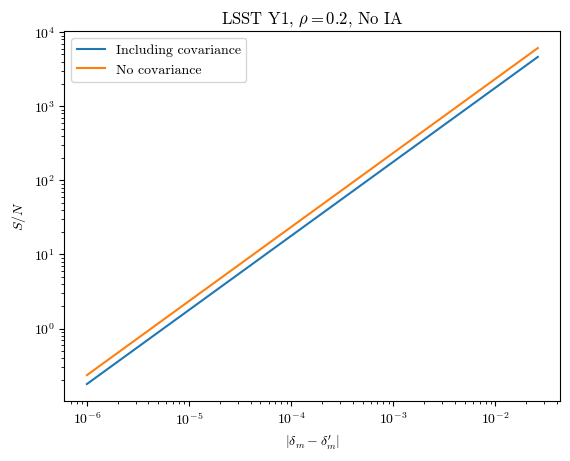

In [417]:
plt.plot(abs(mdiff), SNR)
plt.plot(abs(mdiff), snr)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$S/N$')
plt.xlabel(r'$|\delta_m - \delta_m^\prime|$')
plt.title(r'LSST Y1, $\rho=0.2$, No IA')
plt.savefig('SNR_LSST_Y1.png')
plt.legend(['Including covariance', 'No covariance'])

In [381]:
print(abs(snr))
print(SNR)

[428.02025827 419.37338436 410.72651046 402.07963655 393.43276265
 384.78588874 376.13901484 367.49214093 358.84526703 350.19839313
 341.55151922 332.90464532 324.25777141 315.61089751 306.9640236
 298.3171497  289.6702758  281.02340189 272.37652799 263.72965408
 255.08278018 246.43590627 237.78903237 229.14215847 220.49528456
 211.84841066 203.20153675 194.55466285 185.90778894 177.26091504
 168.61404113 159.96716723 151.32029333 142.67341942 134.02654552
 125.37967161 116.73279771 108.0859238   99.4390499   90.792176
  82.14530209  73.49842819  64.85155428  56.20468038  47.55780647
  38.91093257  30.26405867  21.61718476  12.97031086   4.32343695
   4.32343695  12.97031086  21.61718476  30.26405867  38.91093257
  47.55780647  56.20468038  64.85155428  73.49842819  82.14530209
  90.792176    99.4390499  108.0859238  116.73279771 125.37967161
 134.02654552 142.67341942 151.32029333 159.96716723 168.61404113
 177.26091504 185.90778894 194.55466285 203.20153675 211.84841066
 220.49528456